# <h1><center> Data-mined Prediction of Tetrahedral Site Occupation in Inorganic Materials </center></h1>

- **Fall 2019 Data Science 100 / 200 Final Project**
- **KyuJung Jun & Deep Dayaramani**

# 1. Introduction

<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Inorganic materials make up a large portion in functional materials, ranging from electrodes for battery applications, fast ionic conductors, semiconductors to thermoelectric materials. In the field of materials science, structure - property relationship is the core of most of materials design problems. Inevitably, in order to discover a novel material with a superb functional property, we tend to start from existing known crystal structures and dope them, or come up with a completely new structure that has not been reported. However, in both cases, the challenges that we face when we play with crystal structures and atomic positions is that we do not have a reliable way to quickly evaluate whether a certain structure with atomic configuration is stable or not. Although quantum mechanical calculations using density functional theory can accurately provide the energetics of a structure within ~ 1meV/atom scale, the cost is too high to be employed for high-throuput manner.

<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Given an anion framework, the site for cations to sit are usually limited to a few atomic positions where the positive charge of a cation is well surrounded by a number of anions to reduce the total energy. The most prevalent type of coordination in inorganic crystals are a *tetrahedral site* and an *octahedral site*. In these cases, the anions build a tetrahedron or an octahedron, and a cation sits in the center of the polyhedron to build this ionic crystal structure. According to previous studies by G. Hautier $^{1}$ and G. Ceder  $^{2}$, lithium atoms tend to occupy mostly tetrahedral and octahedral sites among a wide variety of coordination environments. 

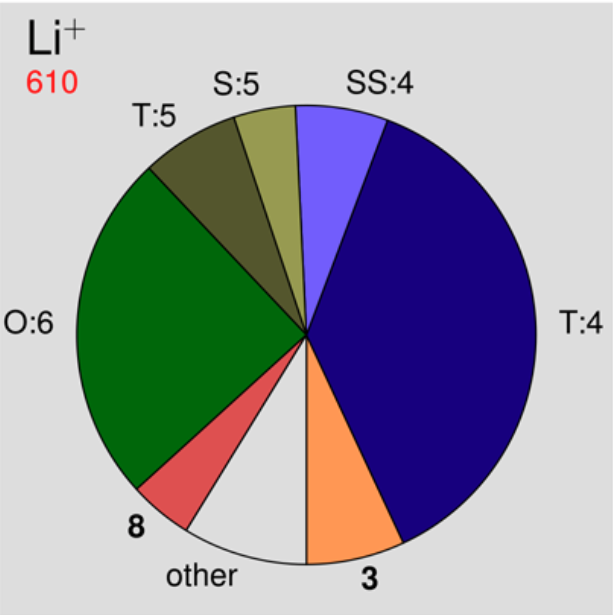
**Figure 1.** The statistical analysis of the coordination environments in Li-containing oxides. T:4 represents tetrahedral site and O:6 represents octahedral site. We can find that tetrahedral and octahedral sites occur more than 70% in the entire distribution.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Especially, in case of doping a certain element into a structure (even dilute doping case), the materials science community do not have a well defined rules that govern whether some dopants can be doped and other cannot. The issue of evaluating dopability is an important yet difficult problem in a wide range of materials design studies. Therefore, in this study, we aim to shed light on this *dopability* problem. Specifically, we pose the problem as follows. Restricting the cation of interest to only lithium, which is one of the most studied element for energy applications, and restricting the coordination environment of interest to only tetrahedral sites, we predict whether the lithium atom will occupy a given tetrahedral site turning it into a classification problem.

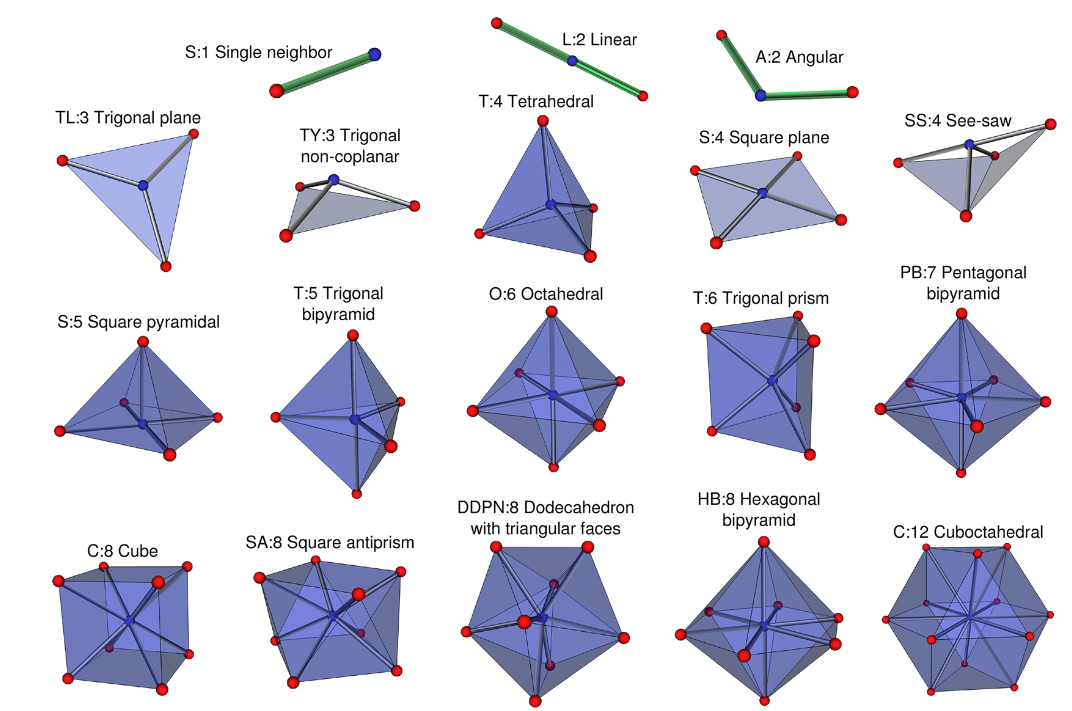
**Figure 2.** The standard symbol of various coordination environments $^{1}$. In this study, only the tetrahedral site is considered.

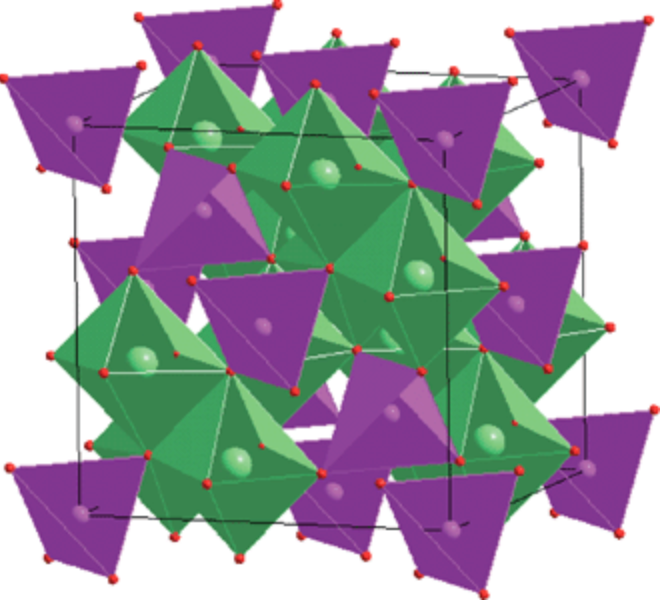

# 2. Method and Data Collection
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We use the structures from the Materials Project database $^{3}$, a DFT-calculated database of all known inorganic crystal structures and a set of hypothetical structures. We collect all of the ternary lithium oxides allowing up to 50 meV/atom energy above hull. The reason for restricting only to ternary lithium oxides is because we want to directly observe the competition for a tetrahedral site between lithium and a non-lithium cation, which will be called X. By restricting up to 50 meV/atom, we can safely argue that these compounds have reasonablly stable site occupations. These ternary compounds are written as Li-X-O.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The general structure analysis was performed using *pymatgen*$^{4}$ package and the coordination environment analysis was performed using specifically *chemenv*$^{5}$ module in *pymatgen*. The statistical analysis was performed using *scikit-learn* package.

In [1]:
#!pip install pymatgen

In [2]:
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import numpy as np
from pymatgen.core import Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.core.composition import *
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder
from pymatgen.analysis.chemenv.coordination_environments.structure_environments import LightStructureEnvironments
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import SimplestChemenvStrategy
from scipy.spatial import ConvexHull
from pymatgen.core.periodic_table import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.stats import uniform
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 2.1 Data collection procedure
* Initial database : Materials project Ternary Li-oxides (Total of 1,830 structures to start with)
* After removing structures that have higher than 50 meV/atom above hull, we get 869 entries left.
* A portion of these 869 entries are removed based on the coordination environment analysis if:

(1) the structure does not contain any occupied tetrahedral site, regardless of the occupying element (Li or X)


(2) lithium atom occupy multiple kinds of coordination environments (we only want a single element to occupy a single kind of site by symmetry)

(3) the atom X occupy multiple kinds of coordination environments
<br>Then, we end up with a total of 156 ternary Li-oxides for modelling.

In [3]:
df = pd.read_pickle("Tetrahedral-Dataset_V4.pickle")

In [4]:
print(df.columns)

Index(['mpid', 'struct', 'formula', 'X_species', 'tet_li', 'tet_X',
       'Tetrahedral_Occupancy', 'Tetrahedral_Volume', 'Tet_CSM',
       'Competing_Volume', 'Competing_Environment', 'Competing_CSM',
       'X_charge', 'X Ionic Radius', 'X Atomic Radius', 'X Electronegativity',
       'competing_row', 'competing_group', 'competing_block'],
      dtype='object')


In [5]:
df.head()

,mpid,struct,formula,X_species,tet_li,tet_X,Tetrahedral_Occupancy,Tetrahedral_Volume,Tet_CSM,Competing_Volume,Competing_Environment,Competing_CSM,X_charge,X Ionic Radius,X Atomic Radius,X Electronegativity,competing_row,competing_group,competing_block
0,mp-1177528,"{'@module': 'pymatgen.core.structure', '@class...",Li3Ti7O14,Ti,"{'oct': [], 'tet': [{'csm': 0.0022241712812721...","{'oct': [{'csm': 0.6215316794802629, 'vol': 10...",Li,4.201175,0.001484,10.648055,oct,0.606701,3.571429,0.745,1.76,1.54,4,4,d
1,mp-976726,"{'@module': 'pymatgen.core.structure', '@class...",LiDyO2,Dy,"{'oct': [], 'tet': [{'csm': 1.601612267430422,...","{'oct': [{'csm': 0.521012997254456, 'vol': 16....",Li,4.160156,1.601607,16.077181,oct,0.521007,3.000000,1.052,2.28,1.22,8,12,f
2,mp-771290,"{'@module': 'pymatgen.core.structure', '@class...",LiMn2O4,Mn,"{'oct': [], 'tet': [{'csm': 0.1071326396070336...","{'oct': [{'csm': 0.5747060430678905, 'vol': 9....",Li,3.664453,1.060414,10.626605,oct,0.692949,3.500000,0.670,1.61,1.55,4,7,d
3,mp-772147,"{'@module': 'pymatgen.core.structure', '@class...",LiNb7O12,Nb,"{'oct': [{'csm': 28.007747747947796, 'vol': 10...","{'oct': [{'csm': 0.22608504681156708, 'vol': 1...",Nb,3.078004,9.909873,10.042085,oct,28.007748,3.285714,0.860,1.98,1.60,5,5,d
4,mp-772108,"{'@module': 'pymatgen.core.structure', '@class...",LiTi11O20,Ti,"{'oct': [], 'tet': [{'csm': 11.715618783359764...","{'oct': [{'csm': 0.5485547790999911, 'vol': 10...",Li,3.380015,11.715619,10.749769,oct,0.486442,3.545455,0.745,1.76,1.54,4,4,d


In [6]:
print("Number of data points: ", len(df))

Number of data points:  156


## 2.2 Feature extraction

1. Feature 1 : Volume of the tetrahedral site (unit in $\unicode{x212B}^3$)
2. Feature 2 : Volume of the competing site (e. g. octahedral sites) (unit in $\unicode{x212B}^3$) 
3. Feature 3 : Pauling's electronegativity value of X
4. Feature 4 : Ionic radius of X - Since we are focused on the competition between Li and other cation for a given tetrahedral site, this property is likely to be the most important feature. If the radius of element X is too large, then this would be difficult to occupy a tetrahedral site of a certain volume. On the other hand, if the radius of element X is too small, the energy will be higher (unstable) because the bonding of X-O is almost broken.
5. Feature 5 : Atomic radius of X - This will be less relevant than the ionic radius, but is still included. 
6. Feature 6 : Coordination symmetry measure (CSM) value of a tetrahedral site. The smaller the CSM value, the more symmetric the geometry is. CSM ranges from 0 to 100, 0 being perfectly symmetric and 100 being totally distorted.
7. Feature 7 : Coordination symmetry measure (CSM) value of a competing octahedral site.
8. Feature 8 : Element X
9. Feature 6 : Row of the element X in the periodic table. This can be done as one-hot encoding for different parts of periodic table, such as: "Is it a transition metal?", "Is it an Alkali metal?", "Is it an Alkali earth metal?", "Is it rare earth?".
11. Feature 11 : Column of the element X in the periodic table
12. Feature 12 : Block of the element X in the periodic table (s, p, d, f-block are the possibilities)

These features build up the original dataframe.


The y vector should be made from the column "Tetrahedral Occupancy". Value "1" is assigned if this column value is "Li" (meaning that the tetrahedral site is occupied to lithium) and "0" if this column is not "Li" (meaning that another cation occupies the tetrahedral site in this structure). This is the variable that we aim to predict in this study.

The initial DataFrame object is saved into Tetrahedral-Dataset_V4.pickle file and is loaded into *df*.

## 2.3 Exploratory Data Analysis (EDA)

In [7]:
df.describe()

,Tetrahedral_Volume,Tet_CSM,Competing_Volume,Competing_CSM,X_charge,X Ionic Radius,X Atomic Radius,X Electronegativity,competing_row,competing_group
count,156.000000,1.560000e+02,1.560000e+02,156.000000,156.000000,156.000000,151.000000,156.000000,156.000000,156.000000
mean,3.640856,2.685024e+00,1.238355e+01,3.503847,3.639178,0.796135,1.643576,1.680769,4.512821,7.442308
std,0.635372,4.509254e+00,3.336511e+00,6.921897,1.022891,0.180092,0.275875,0.296838,1.307483,3.362488
min,0.876182,2.755066e-17,1.636495e-07,0.000040,1.000000,0.000000,0.530000,1.100000,1.000000,1.000000
25%,3.461709,5.566409e-02,1.015381e+01,0.593653,3.000000,0.680000,1.540000,1.540000,4.000000,5.000000
50%,3.772226,7.680340e-01,1.072919e+01,0.789219,3.547727,0.745000,1.610000,1.550000,4.000000,7.000000
75%,4.069270,3.254739e+00,1.401431e+01,1.969925,4.000000,0.902500,1.760000,1.880000,4.250000,10.000000
max,4.991710,2.685820e+01,2.593375e+01,38.993163,7.000000,1.290000,2.470000,3.160000,9.000000,17.000000


### 2.3.1 Observing the volume range
By observing the volume range of tetrahedral and octahedral sites, we find an entry with near zero volume of octahedral site. We also find an entry with tetrahedrals site volume smaller than 1 $A^3$. These points may be from an error in analyzing the coordination environment, so it is removed for further data analysis.

Text(0.5, 1.0, 'Volume range of tetrahedral and octahedral sites')

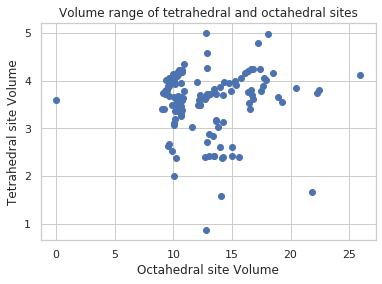

In [8]:
tet_vol = df['Tetrahedral_Volume']
oct_vol = df['Competing_Volume']
plt.scatter(y=tet_vol, x=oct_vol)
plt.xlabel("Octahedral site Volume")
plt.ylabel("Tetrahedral site Volume")
plt.title("Volume range of tetrahedral and octahedral sites")

In [9]:
df[df['Competing_Volume'] <1].index

Int64Index([63], dtype='int64')

In [10]:
df[df['Tetrahedral_Volume']<1].index

Int64Index([24], dtype='int64')

Text(0.5, 1.0, 'Modified Volume range of tetrahedral and octahedral sites without outliers')

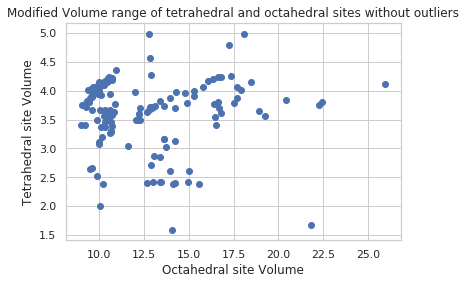

In [11]:
df = df.drop([24, 63])
df = df.reset_index(drop=True)
tet_vol = df['Tetrahedral_Volume']
oct_vol = df['Competing_Volume']
plt.scatter(y=tet_vol, x=oct_vol)
plt.xlabel("Octahedral site Volume")
plt.ylabel("Tetrahedral site Volume")
plt.title("Modified Volume range of tetrahedral and octahedral sites without outliers")

### 2.3.2 Observing relationship between the ionic radius and atomic radius
Two information on the ionic radius and atomic radius is included in the dataframe. In order to find out how these are related, which one is bigger and smaller, we make a scatter plot for these two features. According to this plot, we found that for every elements, the atomic radius is larger than the ionic radius. This is because we only consider the oxides. Therefore, due to the high electronegativity of oxygen anion, these X elements appear in cation form. Cations tend to have smaller radius since they lose the valence electrons. We find two entries that have zero-ionic radius. Upon observation, this turns out to be H+ cation, which actually have negative radius. So these entries are not dropped.

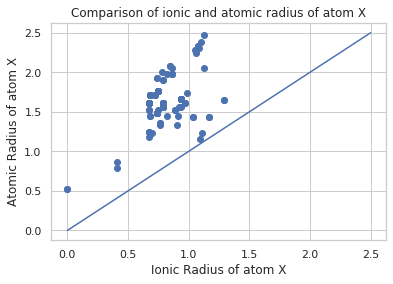

In [12]:
ionic = df['X Ionic Radius']
atomic = df['X Atomic Radius']
plt.scatter(y=atomic, x=ionic)
plt.xlabel("Ionic Radius of atom X")
plt.ylabel("Atomic Radius of atom X")
plt.title("Comparison of ionic and atomic radius of atom X")
plt.plot(np.linspace(0, 2.5, 50), np.linspace(0, 2.5, 50))

In [13]:
df[df['X Ionic Radius']==0].index

Int64Index([23, 122], dtype='int64')

In [14]:
df.iloc[122,:]

mpid                                                              mp-23856
struct                   {'@module': 'pymatgen.core.structure', '@class...
formula                                                               LiHO
X_species                                                                H
tet_li                   {'oct': [], 'tet': [{'csm': 2.9352193299560865...
tet_X                    {'oct': [{'csm': 6.794934899319614, 'vol': 18....
Tetrahedral_Occupancy                                                   Li
Tetrahedral_Volume                                                 3.65614
Tet_CSM                                                            2.93522
Competing_Volume                                                   18.8989
Competing_Environment                                                  oct
Competing_CSM                                                      6.79493
X_charge                                                                 1
X Ionic Radius           

This entry with zero ionic radius of cation X is lithium hydroxide (LiOH). According to the database of ionic radius, hydrogen cation indeed have a negative value of ionic radius. This is not an outlier, but a reasonable value. Therefore it is included in further analysis.

## 2.4 Data Selection and Cleaning
In this part we first fill in the NaN values and find further information of the row and column numbers for X_species. As shown in the cell below, "X Atomic Radius" column have 5 missing points, so these are manually added.

In [15]:
df.isna().sum()

mpid                     0
struct                   0
formula                  0
X_species                0
tet_li                   0
tet_X                    0
Tetrahedral_Occupancy    0
Tetrahedral_Volume       0
Tet_CSM                  0
Competing_Volume         0
Competing_Environment    0
Competing_CSM            0
X_charge                 0
X Ionic Radius           0
X Atomic Radius          4
X Electronegativity      0
competing_row            0
competing_group          0
competing_block          0
dtype: int64

In [16]:
df[df['X Atomic Radius'].isna()]

,mpid,struct,formula,X_species,tet_li,tet_X,Tetrahedral_Occupancy,Tetrahedral_Volume,Tet_CSM,Competing_Volume,Competing_Environment,Competing_CSM,X_charge,X Ionic Radius,X Atomic Radius,X Electronegativity,competing_row,competing_group,competing_block
41,mp-8609,"{'@module': 'pymatgen.core.structure', '@class...",Li6UO6,U,"{'oct': [], 'tet': [{'csm': 4.581002814980115,...","{'oct': [{'csm': 0.5214358834590197, 'vol': 12...",Li,3.490418,4.581002,12.270320,oct,0.521436,6.0,0.870,NaN,1.38,9,6,f
89,mp-1020057,"{'@module': 'pymatgen.core.structure', '@class...",LiLaO2,La,"{'oct': [], 'tet': [{'csm': 3.1962162781159327...","{'oct': [{'csm': 5.61858859069598, 'vol': 17.9...",Li,4.019812,3.196216,17.920330,oct,5.618589,3.0,1.172,NaN,1.10,8,3,f
106,mp-8412,"{'@module': 'pymatgen.core.structure', '@class...",LiCeO2,Ce,"{'oct': [], 'tet': [{'csm': 3.558608219981555,...","{'oct': [{'csm': 6.522500251220635, 'vol': 16....",Li,3.769153,3.558608,16.406546,oct,6.522500,3.0,1.150,NaN,1.12,8,4,f
146,mp-756544,"{'@module': 'pymatgen.core.structure', '@class...",LiLaO2,La,"{'oct': [], 'tet': [{'csm': 7.20535497899418, ...","{'oct': [{'csm': 4.880895797653712, 'vol': 18....",Li,4.976217,7.205355,18.056858,oct,4.880896,3.0,1.172,NaN,1.10,8,3,f


Filling in values of atomic radii

In [17]:
df.loc[106,'X Atomic Radius'] = 2.48
df.loc[146,'X Atomic Radius'] = 2.50
df.loc[89,'X Atomic Radius'] = 2.50
df.loc[41,'X Atomic Radius'] = 2.30
df.isna().sum()

mpid                     0
struct                   0
formula                  0
X_species                0
tet_li                   0
tet_X                    0
Tetrahedral_Occupancy    0
Tetrahedral_Volume       0
Tet_CSM                  0
Competing_Volume         0
Competing_Environment    0
Competing_CSM            0
X_charge                 0
X Ionic Radius           0
X Atomic Radius          0
X Electronegativity      0
competing_row            0
competing_group          0
competing_block          0
dtype: int64

#### Here, we create the y column ("Li"), which tells us about the tetrahedral site is occupied by Li atom or not. Then we create the final_df with the rows we will use for the training and testing data

In [18]:
df['Li'] =[1 if df['Tetrahedral_Occupancy'][i]=='Li' else 0 for i in range(len(df))]

In [19]:
final_occ = df[['X_species','Tetrahedral_Volume','Tet_CSM','Competing_Volume','X_charge','Competing_CSM','X Ionic Radius','X Atomic Radius','X Electronegativity','competing_row','Li']]

Thanks to Goodman Sciences, we got a csv containing data regarding the Periodic Table of Elements. We used this to include the row, column and type for the element X

In [21]:
periodic_table = pd.read_csv('Periodic Table of Elements.csv')

In [22]:
periodic_table_alt = periodic_table[['Symbol','Period','Group','Type']]
periodic_table_alt = periodic_table_alt.rename(columns ={'Symbol':'X_species'})
periodic_table_alt.head(6)

,X_species,Period,Group,Type
0,H,1,1.0,Nonmetal
1,He,1,18.0,Noble Gas
2,Li,2,1.0,Alkali Metal
3,Be,2,2.0,Alkaline Earth Metal
4,B,2,13.0,Metalloid
5,C,2,14.0,Nonmetal


In [23]:
final_occ_alt = pd.merge(final_occ,periodic_table_alt, on='X_species',how='inner')

The next cell includes an assumption for the f-block elements which don't have a group number but transitions from the s-block to the d-block elements

In [24]:
indexing = final_occ_alt[final_occ_alt['Group'].isna()]['Group'].index
final_occ_alt.loc[indexing, 'Group'] = 3.5

We one-hot encoded for the type of material X is from Halogen, Actinide, Lanthanide, Metalloid, Metal or Non-Metal

In [25]:
dummy = pd.get_dummies(final_occ_alt['Type'],drop_first=True)
final_occ_alt = pd.concat([final_occ_alt,dummy],axis=1)

In [26]:
final_occ_alt.columns

Index(['X_species', 'Tetrahedral_Volume', 'Tet_CSM', 'Competing_Volume',
       'X_charge', 'Competing_CSM', 'X Ionic Radius', 'X Atomic Radius',
       'X Electronegativity', 'competing_row', 'Li', 'rounded_charge',
       'Period', 'Group', 'Type', 'Halogen', 'Lanthanide', 'Metal',
       'Metalloid', 'Nonmetal', 'Transition Metal'],
      dtype='object')

#### We perform test-train split of 4:1 ratio. The training is performed on 123 datapoints and the testing is performed on 31 datapoints.

In [27]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_occ_alt, train_size=0.8, test_size=0.2, random_state=1)
print('Train:', train.shape, 'Test:', test.shape)

Train: (123, 21) Test: (31, 21)


# 3. Modelling Result
## 3.1 Initial model and identification of irrelevant features

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Using the design matrix, we model the system using logistic regression. L1 error function is used. We have a total of 15 features in the first model. By using the L1 error function, we were able to identify the features that are not relevant in the prediction.

In [28]:
num_vars = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Competing_CSM', 'X_charge','X Ionic Radius','X Atomic Radius','X Electronegativity','competing_row','Halogen','Lanthanide','Metal','Metalloid','Nonmetal','Transition Metal']
def design_matrix(t, variables):
    """Create a design matrix from dataframe t."""
    scaled = t[variables]
    return scaled
design_matrix(train, num_vars).iloc[0,:]

Tetrahedral_Volume      4.216036
Tet_CSM                 0.000709
Competing_Volume       10.653302
Competing_CSM           0.615022
X_charge                3.562500
X Ionic Radius          0.745000
X Atomic Radius         1.760000
X Electronegativity     1.540000
competing_row           4.000000
Halogen                 0.000000
Lanthanide              0.000000
Metal                   0.000000
Metalloid               0.000000
Nonmetal                0.000000
Transition Metal        1.000000
Name: 19, dtype: float64

In [29]:
clf = LogisticRegression(fit_intercept=True, penalty='l1')
model = clf.fit(design_matrix(train, num_vars), train['Li'])
clf.predict(design_matrix(test, num_vars))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1])

#### The result of the initial model is as follows.
* Training accuracy of 0.9186
* Test accuracy of 0.87096

In [30]:
test_accuracy = met.accuracy_score(test['Li'], clf.predict(design_matrix(test, num_vars)))
training_accuracy = met.accuracy_score(train['Li'], model.predict(design_matrix(train, num_vars)))
print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)

Training Accuracy:  0.9186991869918699
Test Accuracy:  0.8709677419354839


#### By observing the coefficients of the first model, we find that there are 6 features that have *0* coefficient, which indicates that these features are not relevant in predicting the occupation probability. These features are as follows:
* Ionic Radius of X
* (One-Hot) Halogen
* (One-Hot) Lanthanide
* (One-Hot) Metalloid
* (One-Hot) Non-metal
* (One-Hot) Transition Metal
<br><br>
Based on this observation, we find that the one-hot encoding of the block information is not significant in the prediction. One surprising point is that the ionic radius of X, which was expected to be the most significant feature has a zero coefficient. The reason behind this expectation is because these are all oxides. By having the only anion as oxygen, the ionicity of the Li-O bond and X-O bond is expected to be higher than covalency. However, our result may be due to the fact that we also include atomic radius of X as well. Therefore, in the next step, we investigate whether atomic radius is more significant in the prediction, or the ionic radius is more significant by building two distinct models using one of these features.

In [31]:
print(clf.coef_)
print(design_matrix(train,num_vars).loc[0,:])

[[ 2.2262943   0.17152068 -0.198539   -0.04898201 -0.59624018  0.
  -2.09584895 -0.35366524  0.50186781  0.          0.          0.
   0.          0.          0.        ]]
Tetrahedral_Volume      4.201175
Tet_CSM                 0.001484
Competing_Volume       10.648055
Competing_CSM           0.606701
X_charge                3.571429
X Ionic Radius          0.745000
X Atomic Radius         1.760000
X Electronegativity     1.540000
competing_row           4.000000
Halogen                 0.000000
Lanthanide              0.000000
Metal                   0.000000
Metalloid               0.000000
Nonmetal                0.000000
Transition Metal        1.000000
Name: 0, dtype: float64


### Case1 : Modeling with only the ionic radius of X
By excluding the "atomic radius of X" column, we achieve the following metrics.
* Training accuracy : 0.89430
* Test accuracy : 0.87096

In [32]:
only_ionic = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Competing_CSM', 'X_charge','X Ionic Radius','X Electronegativity','competing_row','Halogen','Lanthanide','Metal','Metalloid','Nonmetal','Transition Metal']
clf_ionic = LogisticRegression(fit_intercept=True, penalty='l1')
model_ionic = clf_ionic.fit(design_matrix(train, only_ionic), train['Li'])
test_accuracy_ionic = met.accuracy_score(test['Li'], clf_ionic.predict(design_matrix(test, only_ionic)))
training_accuracy_ionic = met.accuracy_score(train['Li'], model_ionic.predict(design_matrix(train, only_ionic)))
print("Training Accuracy: ", training_accuracy_ionic)
print("Test Accuracy: ", test_accuracy_ionic)

Training Accuracy:  0.8943089430894309
Test Accuracy:  0.8709677419354839


### Case2 : Modelling with only the atomic radius of X
By excluding the "ionic radius of X" column, we achieve the following metrics.
* Training accuracy : 0.9186
* Test accuracy : 0.87096
<br>
For these reasons, we decide to keep only the atomic radius of X and drop the ionic radius column. The physical reason for this can be the fact that the ionic radius differs significantly based on the charge state of the cation. However, here, we simply use the ionic radius that is averaged over all possible charge states and this may lead to slightly lower performance. Still, considering the fact that our dataset is not very large, the performance difference between ionic radius and atomic radius information is small.

In [33]:
only_atomic = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Competing_CSM', 'X_charge','X Atomic Radius','X Electronegativity','competing_row','Halogen','Lanthanide','Metal','Metalloid','Nonmetal','Transition Metal']
clf_atomic = LogisticRegression(fit_intercept=True, penalty='l1')
model_atomic = clf_atomic.fit(design_matrix(train, only_atomic), train['Li'])
test_accuracy_atomic = met.accuracy_score(test['Li'], clf_atomic.predict(design_matrix(test, only_atomic)))
training_accuracy_atomic = met.accuracy_score(train['Li'], model_atomic.predict(design_matrix(train, only_atomic)))
print("Training Accuracy: ", training_accuracy_atomic)
print("Test Accuracy: ", test_accuracy_atomic)

Training Accuracy:  0.9186991869918699
Test Accuracy:  0.8709677419354839


### Case3 : Modelling without the one-hot encoding of the block information
As identified above, the one-hot encoding of the block information had many zero-coefficients. Therefore, here these columns are excluded and the "Group" information, which contains the block information as well, is added. By removing all of the block information, the training accuracy increases

In [34]:
noblock = ['Tetrahedral_Volume','Tet_CSM', 'Competing_Volume', 'Group','Competing_CSM', 'X_charge','X Atomic Radius','X Electronegativity','competing_row']
clf_block = LogisticRegression(fit_intercept=True, penalty='l1')
model_block = clf_block.fit(design_matrix(train, noblock), train['Li'])
test_accuracy_block = met.accuracy_score(test['Li'], clf_block.predict(design_matrix(test, noblock)))
training_accuracy_block = met.accuracy_score(train['Li'], model_block.predict(design_matrix(train, noblock)))
print("Training Accuracy: ", training_accuracy_block)
print("Test Accuracy: ", test_accuracy_block)

Training Accuracy:  0.926829268292683
Test Accuracy:  0.8709677419354839


## 3.2 Performance of our modified logistic regression model
In this section, the performance of our logistic regression model, excluding the irrelevant features is assessed. 
Furthermore, we applied **Randomized Search Cross Validation** to see if any of the training/test accuracies improved. We used different penalties and a regularization parameter- the inverse of regularization strength, to find their best values. Then we evaluated this model using the confusion matrix.

In [35]:
logistic = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

#Using Randomized SearchCV for 100 iterations and 5 fold cross validation. 
clf_log = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)

#Fitting our model
clf_CV_log = clf_log.fit(design_matrix(train,noblock), train['Li'])

# Best Penalty
print('Best Penalty:', clf_CV_log.best_estimator_.get_params()['penalty'])

# Best Regularization Parameter
print('Best C:', clf_CV_log.best_estimator_.get_params()['C'])

#Test Accuracy and Train Accuracy
test_accuracy_block = met.accuracy_score(test['Li'], clf_CV_log.predict(design_matrix(test, noblock)))
training_accuracy_block = met.accuracy_score(train['Li'], clf_CV_log.predict(design_matrix(train, noblock)))
print("Training Accuracy: ", training_accuracy_block)
print("Test Accuracy: ", test_accuracy_block)

#Coefficients of the best estimator
clf_CV_log.best_estimator_.coef_

Best Penalty: l1
Best C: 1.668088018810296
Training Accuracy:  0.926829268292683
Test Accuracy:  0.8709677419354839


array([[ 3.40356317,  0.274851  , -0.13441711, -0.19765579, -0.02939432,
        -0.25683598, -6.42876823, -0.60212676,  1.06314673]])

In [36]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Function was used in one of the homeworks for Data 100
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    print(cm)
    classes = ['Other','Li']    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title, y=1.3)

In [37]:
def evaluate(model, test_features, test_labels):
    """ This function plots the confusion matrix 
    and finds accuracy, precision and recall.
    """
    y_pred = model.predict(test_features)
    y_test = test_labels
    cnf_matrix = met.confusion_matrix(y_test, y_pred)
    accuracy = met.accuracy_score(y_test,y_pred)
    precision = met.precision_score(y_test,y_pred)
    recall = met.recall_score(y_test,y_pred)
    plot_confusion_matrix(cnf_matrix)
    print('Model Performance')
    print('Precision is')
    print(precision)
    print('Accuracy is')
    print(accuracy)
    print('Recall is')
    print(recall)
    return 

[[ 3  4]
 [ 0 24]]
Model Performance
Precision is
0.8571428571428571
Accuracy is
0.8709677419354839
Recall is
1.0


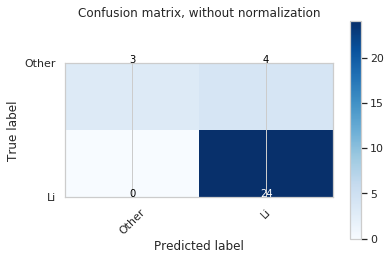

In [38]:
evaluate(clf_CV_log.best_estimator_,design_matrix(test,noblock),test['Li'])

## 3.3 Random Forest Classifier
* We tried to use the Random Forest Model to try and improve on the accuracy scores from the logistic regression.
* We used the same features as in the noblock, and used Randomized Search Cross Validation over a bunch of different values of n_estimators, max_features, max_depth, samples split, samples leaf, and bootstrap to find the best hyperparameters for the random forest model.
* After tuning hyperparameters, we evaluated our model using the confusion matrix. The Random Forest Classifier has a 100% accuracy for both testing and training data. 



In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(8, 96, num = 12)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, None], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [40]:
clf_forest = RandomForestClassifier()

#Forming a Randomized Search CV on our Random Forest Classifier
clf_random = RandomizedSearchCV(estimator = clf_forest, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=0, random_state=1, n_jobs = -1)

#fitting our model
clf_random.fit(design_matrix(train,noblock),train['Li'])

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, None], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [41]:
print('Best n_estimators:', clf_random.best_estimator_.get_params()['n_estimators'])
print('Best max_features:', clf_random.best_estimator_.get_params()['max_features'])
print('Best max_depth:', clf_random.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', clf_random.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', clf_random.best_estimator_.get_params()['min_samples_leaf'])
print('Best bootstrap:', clf_random.best_estimator_.get_params()['bootstrap'])
test_accuracy_block = met.accuracy_score(test['Li'], clf_random.predict(design_matrix(test, noblock)))
training_accuracy_block = met.accuracy_score(train['Li'], clf_random.predict(design_matrix(train, noblock)))
print("Training Accuracy: ", training_accuracy_block)
print("Test Accuracy: ", test_accuracy_block)
print("Feature Importance: ",clf_random.best_estimator_.feature_importances_)

Best n_estimators: 200
Best max_features: sqrt
Best max_depth: 64
Best min_samples_split: 2
Best min_samples_leaf: 2
Best bootstrap: True
Training Accuracy:  1.0
Test Accuracy:  0.9354838709677419
Feature Importance:  [0.36788407 0.12718032 0.15026017 0.02857023 0.08566841 0.10353535
 0.04267567 0.06143317 0.03279261]


[[ 6  1]
 [ 1 23]]
Model Performance
Precision is
0.9583333333333334
Accuracy is
0.9354838709677419
Recall is
0.9583333333333334


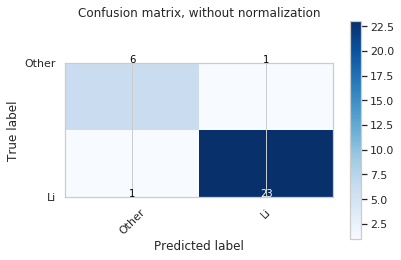

In [42]:
#evaluate our random forest classifier
evaluate(clf_random.best_estimator_,design_matrix(test,noblock),test['Li'])

* As we can see the random forest model correctly predicts most of the test data. To see how it does this with 200 estimators, we decided to see some trees within the forest which is shown below.

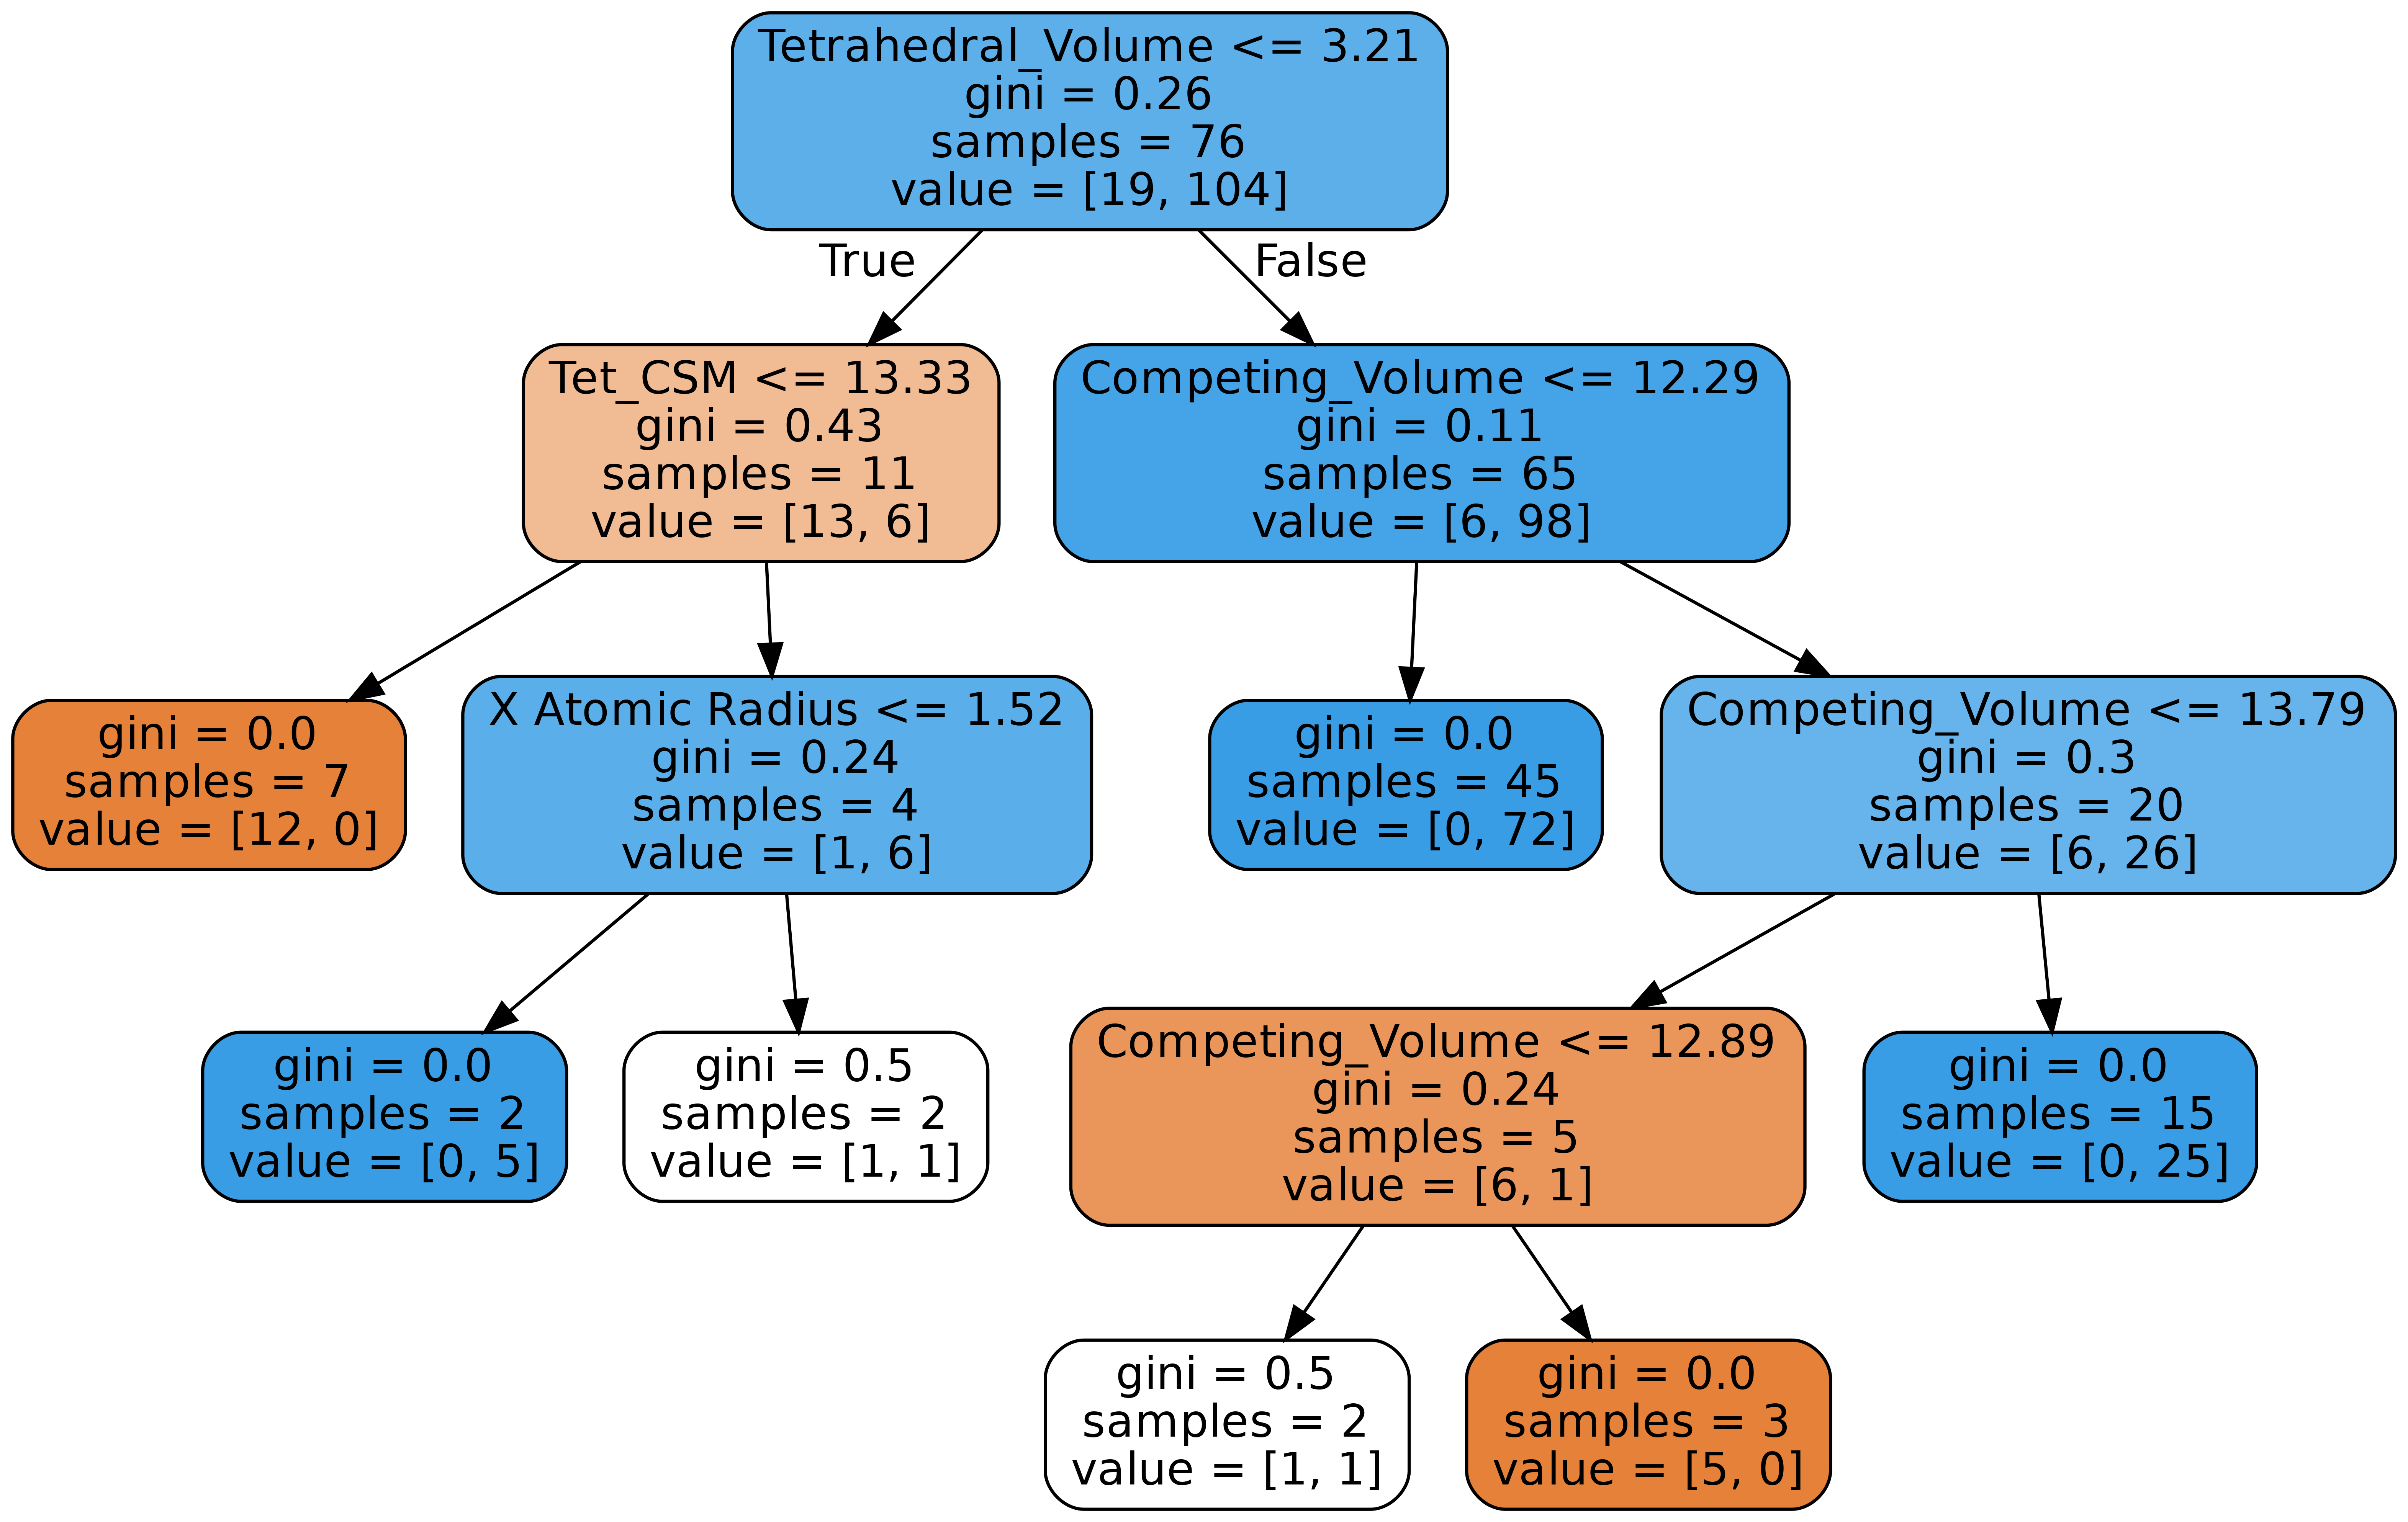

In [43]:
#Visualizing tree #96 in forest
tree_in_forest = clf_random.best_estimator_.estimators_[96]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(tree_in_forest, out_file='tree.dot', 
                feature_names = design_matrix(train,noblock).columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## 3.4 Comparison of the Logistic Regression and Random Forest Classifiers
First we can see the difference in the test accuracy, train accuracy, recall and precision from our evaluate functions. The Random forest classifier has a 93.5% accuracy, 95.88% precision and 95.83% recall for test data, 100% training accuracy whereas the Logistic regression classifier having a 92.86% train accuracy, 87.096% test accuracy, 85.7% precision, 100% recall. The logistic regression model may be better at predicting true positives, the random forest classifier is both more accurate and precise. Using this data, it is clear that the random forest classifier trumps the logistic regression classifier. To further establish the difference in the model results, we plotted the ROC curves below. The ROC_AUC score for the logistic regression model was 0.93 whereas was 0.99 for the random forest model.


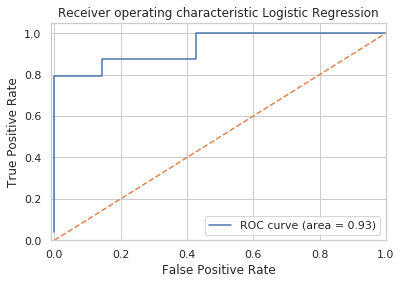

In [52]:
# Logistic Regression
# We found the ROC_AUC which gives us a good idea of how well our model performs.
roc_value = met.roc_auc_score(test['Li'], clf_CV_log.best_estimator_.predict_proba(design_matrix(test,noblock))[:,1])
fpr,tpr,_ = met.roc_curve(test['Li'],clf_CV_log.best_estimator_.predict_proba(design_matrix(test,noblock))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_value)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Logistic Regression')
plt.legend(loc="lower right")
plt.show()

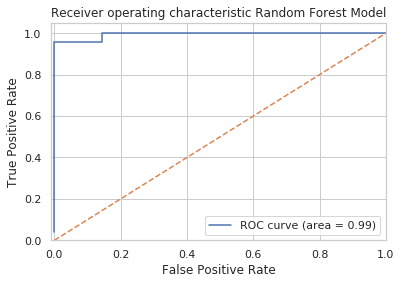

In [53]:
# Random Forest
# Calculate roc auc
# We found the ROC_AUC which gives us a good idea of how well our model performs.
roc_value = met.roc_auc_score(test['Li'], clf_random.best_estimator_.predict_proba(design_matrix(test,noblock))[:,1])
fpr,tpr,_ = met.roc_curve(test['Li'],clf_random.best_estimator_.predict_proba(design_matrix(test,noblock))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_value)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Random Forest Model')
plt.legend(loc="lower right")
plt.show()

## 3.5 Unsupervised Learning via Principal Component Analysis and K-Means Clustering
#### PCA
Here, in order to gain more insight in the occupation preference of atoms, we perform unsupervised learning. First, after standardizing our design matrix, we performed principal component analysis (PCA) and showed all of the datapoints with respect to the two axis that have the highest variance. The red points are the datapoints where lithium atom occupy the tetrahedral site and the grey points are otherwise. Just by looking at the highest variance principal axis, the boundary between these are not clear.

In [46]:
train.columns

Index(['X_species', 'Tetrahedral_Volume', 'Tet_CSM', 'Competing_Volume',
       'X_charge', 'Competing_CSM', 'X Ionic Radius', 'X Atomic Radius',
       'X Electronegativity', 'competing_row', 'Li', 'rounded_charge',
       'Period', 'Group', 'Type', 'Halogen', 'Lanthanide', 'Metal',
       'Metalloid', 'Nonmetal', 'Transition Metal'],
      dtype='object')

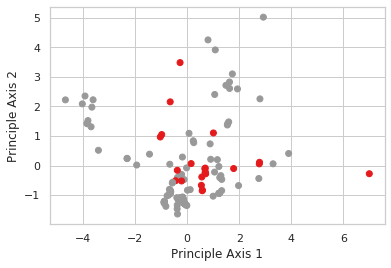

In [47]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
X = design_matrix(train,noblock)
X_scaled = preprocessing.scale(X)

pca = PCA(n_components=2).fit(X_scaled)
pca_2d = pca.transform(X_scaled)
plt.figure('Reference Plot')

plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=train['Li'], cmap='Set1')
plt.xlabel("Principle Axis 1")
plt.ylabel("Principle Axis 2")
plt.show()

#### K-Means Clustering
Now that we have the design matrix in the principal axes, we cluster our datapoints of 2-dimensional principal axis into 8 clusters. We chose the number 8 from the fact that there are 18 columns in the periodic table and we disregarded the non major groups. Our expectation is that each elements that have similar chemical characteristics will group with each other.

[ 0  0  3 15 15 11  6  0  0  0 17  1  0  5  3  5  6  9  0  0  0 15  0  8
  1 17 17  0  5  4 15  5  9 16  9 15  0  0  0  7  0 11  2  6  0 15  9  6
 16  4  0  6  8  1  0  4  0  5  0  0  1  9 11 15 12 14  4  6 10  0  1  9
  7  0 13  0  5 15  0  9  2  4 16  0  0 15  9  1  0  5  5  0  9  9  0  9
  4  0  3  9  0  9  0  7  9  4  6  1  0  2 16  9  0  3  6 11  5 15  6 14
 15  2  0]


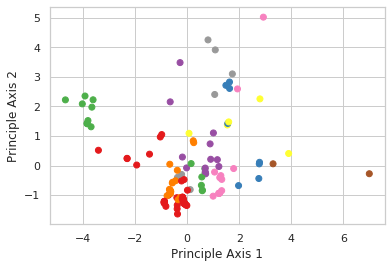

In [50]:
kmeans = KMeans(n_clusters=18, random_state=42)
kmeans.fit(X_scaled)
plt.figure('K-means with 3 clusters')
plt.xlabel("Principle Axis 1")
plt.ylabel("Principle Axis 2")
print(kmeans.labels_)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, cmap='Set1')
plt.show()

In [51]:
dictlist = []
for i in range(len(train)):
    dictlist.append({'Group':kmeans.labels_[i], 'X':list(train['X_species'])[i]})
dictlist = sorted(dictlist,key=lambda x:x['Group'])
#print(dictlist)
groups = []
for i in range(18):
    groupdict = {}
    groupdict = {"Group":i, "Elements":[]}
    for j in dictlist:
        if j['Group']==i:
            groupdict["Elements"].append(j['X'])
    groups.append(groupdict)
for i in groups:
    print(i)

{'Group': 0, 'Elements': ['Ti', 'V', 'Mn', 'Mn', 'Mn', 'Ti', 'Mn', 'Ti', 'Mn', 'Mn', 'Ti', 'Ti', 'Ti', 'V', 'Mn', 'Mn', 'Ti', 'Mn', 'V', 'Mn', 'Ti', 'V', 'Mn', 'Mn', 'Mn', 'Mn', 'Ti', 'Mn', 'Mn', 'Cr', 'Mn', 'Mn', 'Mn', 'Mn', 'Ti', 'Mn']}
{'Group': 1, 'Elements': ['Nb', 'Ta', 'U', 'Hf', 'Nb', 'Zr', 'Hf']}
{'Group': 2, 'Elements': ['Bi', 'Bi', 'Bi', 'Au']}
{'Group': 3, 'Elements': ['Te', 'Ge', 'Ge', 'Sb']}
{'Group': 4, 'Elements': ['Cr', 'Cr', 'Cr', 'Cr', 'V', 'Cr', 'Cr']}
{'Group': 5, 'Elements': ['Nd', 'Ce', 'La', 'Gd', 'Pr', 'Dy', 'Gd', 'Eu', 'Sm']}
{'Group': 6, 'Elements': ['Co', 'Ni', 'Mn', 'Fe', 'Mn', 'Fe', 'Fe', 'Ni', 'In']}
{'Group': 7, 'Elements': ['Nb', 'Cr', 'Nb']}
{'Group': 8, 'Elements': ['Mn', 'Mn']}
{'Group': 9, 'Elements': ['Ti', 'Ti', 'Ti', 'V', 'Ti', 'Ti', 'Ti', 'Ti', 'V', 'Ti', 'Ti', 'Ti', 'Ti', 'Ti', 'Ti']}
{'Group': 10, 'Elements': ['B']}
{'Group': 11, 'Elements': ['Mn', 'Te', 'Cu', 'Cu']}
{'Group': 12, 'Elements': ['H']}
{'Group': 13, 'Elements': ['Cl']}
{'Group': 

#### Interpreting the clustering results
* Group 0 : 3d transition metals
* Group 1 : These are some of the outliers of the data
* Group 2 : Period 6 elements
* Group 3 : Metalloid Elements
* Group 4 : 3d transition metal, Chromium
* Group 5 : These are the lanthanide series elements. 
* Group 6 : Mostly 3d transition metals with the exception of In which could be an outlier.
* Group 7 : These are heavy metals like Nb Cr.
* Group 8 : Only Manganese (3d transition metal).
* Group 9 : Titanium and Vanadium like group 0
* Group 10 : Boron from group 13 as an outlier
* Group 11 : 3d Transition metals with Te as an outlier
* Group 12 : Hydrogen from group 1 as an outlier
* Group 13 : Chlroine from group 17 as an outlier
* Group 14 : Periodic Table Group 15 elements 
* Group 15 : Period 4 elements as 3d transition elements
* Group 16 : Mostly Periodic Table Group 11 elements
* Group 17 : Periodic Table Group 6 elements
<br>
The clustering result based on PCA does interpret the chemical information appropriately, giving some insights from the periodic table.

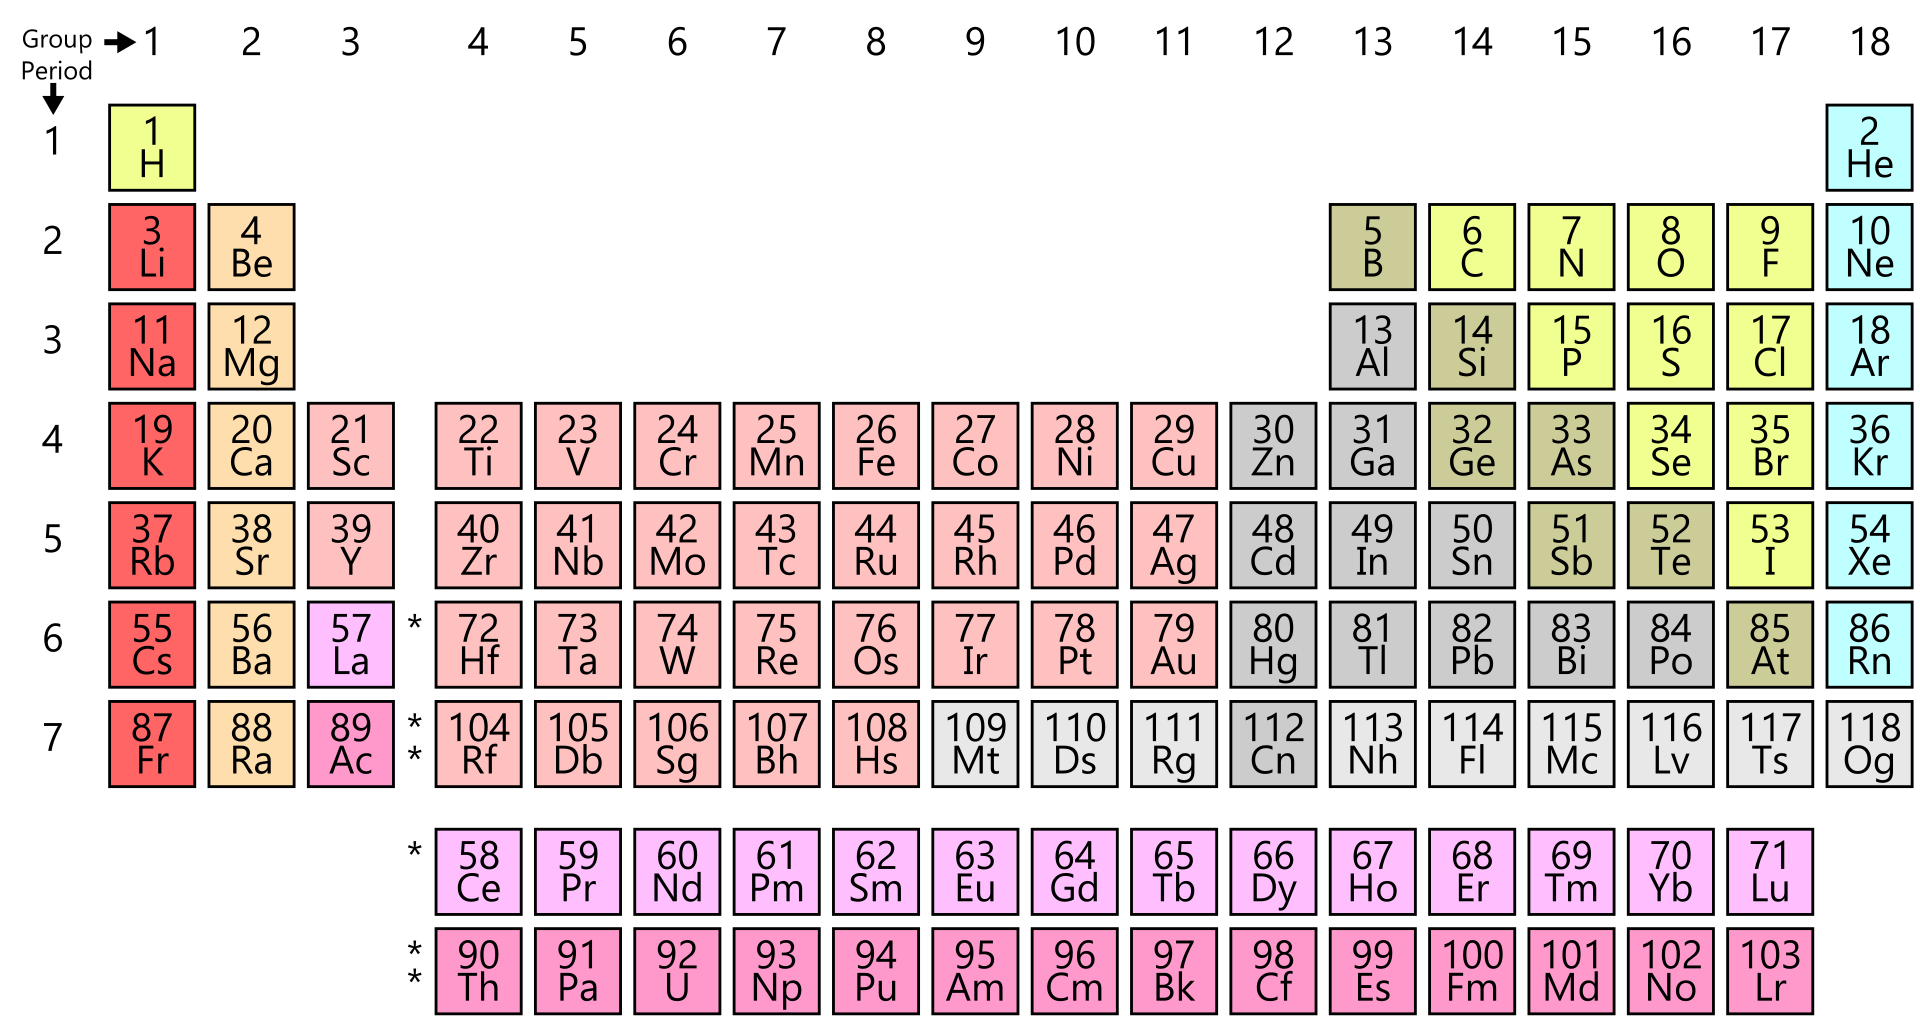

# 4. Discussion
Lithium occupation probability in a tetrahedral site can be well solved by data-mined prediction. Especially the random forest model outperforms the logistic regression model. We can predict with over 90% accuracy whether a Li will occupy a given tetrahedral site, or will lose the competition with the other cation X.


This can be interpreted as two points. The first is the preference of the other cation X for a tetrahedral site. If the cation X prefers very strongly a tetrahedral site, then Li will have smaller chance of occupying that site. For example, Si or P atom almost always takes a tetrahedral site. Therefore, if Li comptete with these elements shown below,  which prefer tetrahedral sites, then Li may not occupy the tetrahedral site.
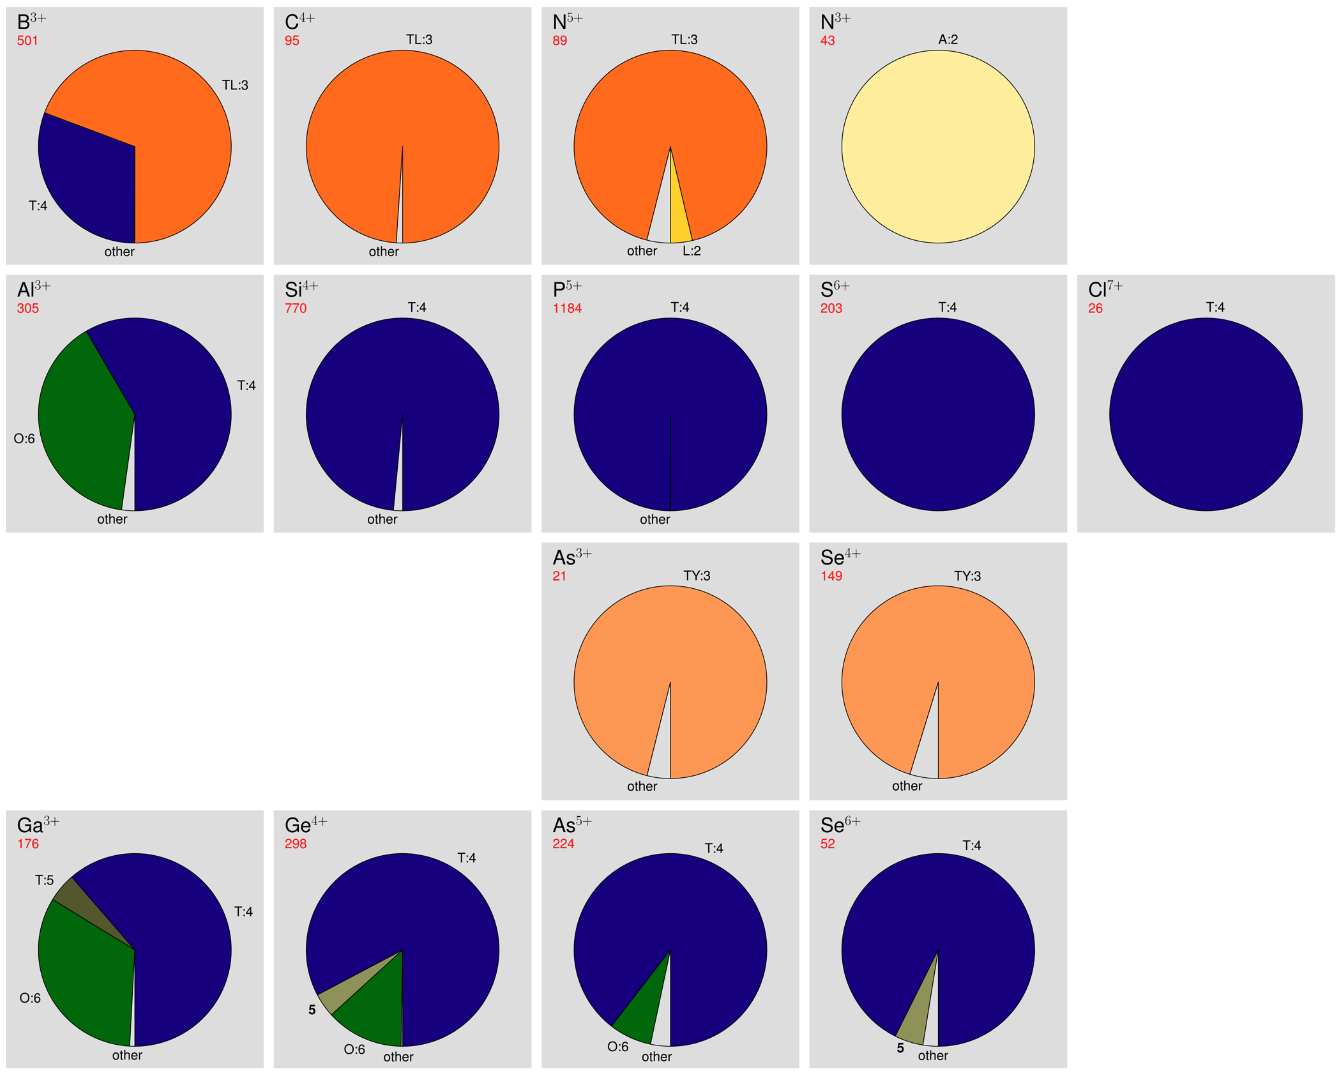
**Figure 4.** Elements that prefer tetrahedral sites $^{1}$. P, Si, Cl, Se and other high-valent cations tend to prefer tetrahedral coordinations.


It is found that atomic radius of X and the volume of the given tetrahedral site is one of the most important feature in determining whether Li will win the competition or not. Assuming valence +1 for lithium, the ionic radius is fixed. Then, there will be an optimal Li-O distance that can stabilize the ionic bonding. For example, as shown below, Buckingham potential, which represents the ionic bonding inorganic materials, have a minimum energy bond length. If the given tetrahedral site geometry differs greatly from this bond length, then it will be energetically unfavorable for lithium to occupy that site. So a sweet spot exist in terms of the volume of the tetrahedral site. Only within a short range of tetrahedral site volume, lithium occupies such site. Otherwise, other element that better fit into that tetrahedral site wins the competition.
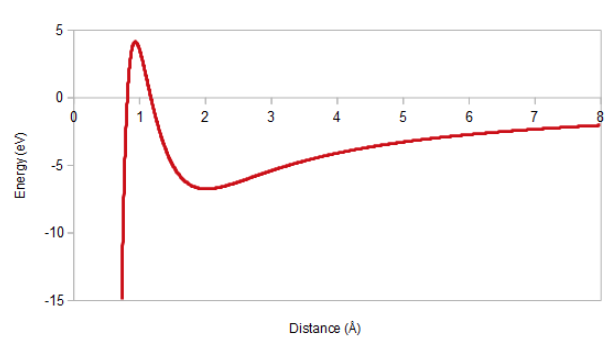

The limitation of this study is that after the data cleaning step, we do not have sufficiently large dataset for learning (slightly over 150 entries). Although this study focused on a single environment (Tetrahedral site) and a single target element (Lithium), by expanding the target environment to octahedral sites and the target elements to all of the alkali / alkali earth metal elements, we expect that his model will be able to be generalized.


The predictablility of this model really comes into power when we design new materials *in silico*. This study can provide insights in whether lithium will be intercalated (added) into a structural framework that contains a tetrahedral site. Also this model will be able to answer the question of dopability, i.e., whether a certain element can be doped into another elements' site.

# Reference

(1) D. Waroquiers, G. Hautier et al., *Statistical analysis of coordination environments in oxides*, Chemistry of Materials, 2017.


(2) G. Hautier, G. Ceder et al., *Data Mined Ionic Substitutions for the Discovery of New Compounds*, Inorganic Chemistry, 2011.